In [1]:
# Install the micrograd library (used for automatic differentiation)
!pip install micrograd

In [2]:
# Import required libraries
from micrograd.engine import Value   # Value class for building computational graphs
import math                          # For mathematical functions like exp, tanh
import numpy as np                   # For array operations
import matplotlib.pyplot as plt      # For plotting functions

In [3]:
# Define a simple quadratic function
def f(x):
  return 3*x**2-4*x + 5

f(3)  # Evaluate the function at x=3

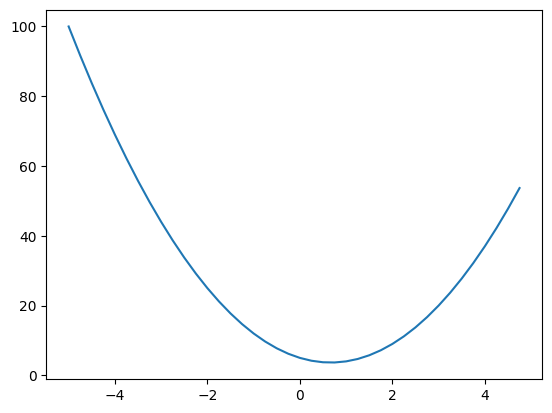

In [5]:
# Generate input values from -5 to 5 with step size 0.25
xs = np.arange(-5,5,0.25)
ys = f(xs)        # Apply function f to all xs
plt.plot(xs, ys)  # Plot the curve

In [6]:
# Numerical differentiation (approximate derivative with small h)
h = 1e-6
x = 2/3
(f(x+h) - f(x)) / h   # Approx derivative of f at x=2/3

2.999378523327323e-06

In [8]:
h = 0.0001   # Step size for numerical gradient

# Inputs again
a = 2.0
b = -3.0
c = 10.0

# Compute d1 and d2 to approximate derivative w.r.t c
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)   # Numerical slope wrt c

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [21]:
# Custom implementation of Value class (like micrograd’s Value)
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data      # Actual scalar value
    self.grad = 0.0       # Gradient (derivative)
    self._backward = lambda: None  # Backward function
    self._prev = set(_children)    # Child nodes
    self._op = _op                 # Operation type
    self.label = label             # Optional label

  def __repr__(self):
    return f"Value(data={self.data})"

  # Overload addition
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):  # Right addition
    return self * other

  # Overload multiplication
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):  # Right multiplication
    return self * other

  # Exponential function
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  # Power operator
  def __pow__(self, other):
    assert isinstance(other, (int,float)), "Only int/float powers supported"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  # Division
  def __truediv__(self, other):
    return self * other**-1

  # Negation
  def __neg__(self):
    return self * -1

  # Subtraction
  def __sub__(self, other):
    return self + (-other)

  # Hyperbolic tangent activation
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  # Backpropagation
  def backward(self):
    topo = []   # Topological ordering
    visited = set()
    def buid_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          buid_topo(child)
        topo.append(v)
    buid_topo(self)

    self.grad = 1.0  # Seed gradient
    for node in reversed(topo):
      print(node)
      node._backward()

In [10]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [11]:
# Graphviz to visualize computation graphs
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
# Example forward pass with manual graph construction
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)   # Tanh
o.label = 'o'
o.backward()            # Run backprop

Value(data=0.7071067811865477)
Value(data=0.1464466094067262)
Value(data=6.828427124746192)
Value(data=1)
Value(data=4.828427124746192)
Value(data=5.828427124746192)
Value(data=1.7627471740390863)
Value(data=0.8813735870195432)
Value(data=6.881373587019543)
Value(data=-6.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=2)
Value(data=-1)


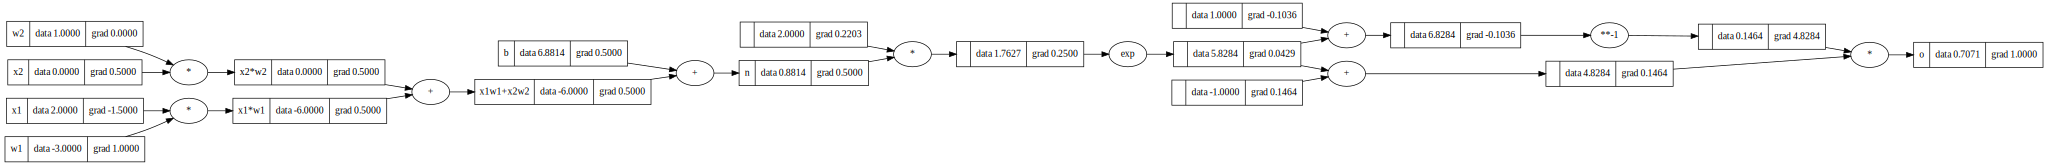

In [13]:
draw_dot(o)

In [14]:
# Compare with PyTorch implementation
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)          # Tanh activation
print(o.data.item())
o.backward()               # Backprop in PyTorch

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [142]:
# Define a simple artificial neuron
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # Random weights
    self.b = Value(random.uniform(-1,1))                        # Random bias
  def parameters(self):
    return self.w + [self.b]
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # Weighted sum + bias
    out = act.tanh()   # Apply tanh activation
    return out

# Layer containing multiple neurons
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def paramaters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

# Multi-Layer Perceptron (MLP)
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)   # Sequentially apply layers
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.paramaters()]

# Test with 3 inputs, 2 hidden layers, 1 output
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=0.7028171911318761)

In [143]:
# Training dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [192]:
# Training loop
for k in range(30):
  ypred = [n(x) for x in xs]   # Forward pass
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))  # Mean Squared Error
  for p in n.parameters():
    p.grad = 0.0  # Reset gradients
  loss.backward() # Backpropagation
  for p in n.parameters():
    p.data += -0.05 * p.grad   # Gradient descent step
  print(k, loss.data)          # Print epoch and loss


Value(data=0.0006043496244164197)
Value(data=0.00028145383229801553)
Value(data=-0.016776585835563074)
Value(data=0.9832234141644369)
Value(data=2.386247286432235)
Value(data=0.9524841392277154)
Value(data=0.8294644272751652)
Value(data=1.1864173138330725)
Value(data=0.2702842002992788)
Value(data=0.9161331135337936)
Value(data=0.040989783631432734)
Value(data=0.8751433299023609)
Value(data=0.6908505171582858)
Value(data=0.18429281274407505)
Value(data=0.6448122543350995)
Value(data=1.4337631472045196)
Value(data=1.2732654428733072)
Value(data=0.8815756664345601)
Value(data=1.382795301964573)
Value(data=1.1704061344502013)
Value(data=1.243040479965778)
Value(data=0.5965370898102118)
Value(data=0.7556310839425227)
Value(data=0.6465033901555661)
Value(data=-0.0726343455155766)
Value(data=0.2123891675143716)
Value(data=0.16049770433121247)
Value(data=0.37742244316973794)
Value(data=0.23441252351899863)
Value(data=0.5245734604815442)
Value(data=0.5826287864232893)
Value(data=0.382906644033

In [193]:
ypred  # Final predictions

[Value(data=0.9603521969340774),
 Value(data=-0.9902291737173405),
 Value(data=-0.9853361579077154),
 Value(data=0.9835604310230752)]